In [238]:
import matplotlib.pyplot as plt
import numpy as np
# import scipy
# from scipy.optimize import leastsq,curve_fit
import cv2
# from scipy import interpolate
# from skimage import filters,io
np.set_printoptions(threshold=np.inf)

In [239]:
#读取原图片
def load_image(file_path,file_name,file_ext):
    file = file_path + file_name + file_ext;
    Image = cv2.imread(file,0); #cv加载的图片灰度为0~255
    ret, Binary = cv2.threshold(Image, 0, 255, cv2.THRESH_BINARY)
    [image_y_max,image_x_max] = Binary.shape;
    print(f"原图片高度：{image_y_max},原图片宽度：{image_x_max}");
    
    plt.imshow(Binary,cmap = "gray");
    plt.show();
    for x in range(0,image_x_max):
        for y in range(0,image_y_max):
            if (Binary[y,x] != 0):
                Binary[y,x] = 1;
    return Binary;

In [240]:
# 识别端点
def GetEndPoints(Image):
    LeftTopNeighbors = [(-1,-1), (0, -1), (1, -1),(-1,0)];
    LeftBottomNeighbors = [(-1,-1),(0,-1),(1,-1),(1,0)];
    RightTopNeighbors = [(-1,0),(-1,1),(0,1),(1,1)];
    RightBottomNeighbors = [(1,0),(-1,1),(0,1),(1,1)];
    [image_y_max,image_x_max] = Image.shape;
    LeftEndPoints = [];
    RightEndPoints = [];
    for y in range(1,image_y_max-1):
        for x in range(1,image_x_max-1):
            if Image[y,x] != 0:
                sum_neighbors = 0;
                for neighbor in LeftTopNeighbors:
                    [dy, dx] = neighbor;
                    sum_neighbors += Image[y+dy,x+dx];
                if sum_neighbors == 0: #是一个端点。
                   #print(f"x:{x},y:{y}\n");
                   LeftEndPoints.append([y,x]);  
                   break;             
                sum_neighbors = 0;
                for neighbor in RightBottomNeighbors:
                    [dy, dx] = neighbor;
                    sum_neighbors += Image[y+dy,x+dx];
                if sum_neighbors == 0: #是一个端点。
                   #print(f"x:{x},y:{y}\n");
                   RightEndPoints.append([y,x]); 
                   break;
    return LeftEndPoints,RightEndPoints;

In [241]:
#返回需要连接的点对
#!!!! 有可能在一个地方识别出多个端点，考虑在配对后，删除附近一定范围内的端点
def GetEndPointsPair(LeftEndPoints,RightEndPoints):
    leftnum = len(LeftEndPoints);
    #print(f"左端点数目:{leftnum}\n");
    rightnum = len(RightEndPoints);
    #print(f"右端点数目:{rightnum}\n");
    #计算左右点对之间的距离。
    distance = np.zeros((leftnum,rightnum),dtype=float);
    for l in range(0,distance.shape[0]):
        for r in range(0,distance.shape[1]):
            left = LeftEndPoints[l];
            right = RightEndPoints[r];
            distance[l,r] =np.sqrt(pow (left[0] - right[0],2) + pow(left[1] - right[1],2));
    #依次寻找距离最小的左端点、右端点对，也就是需要连接的点，然后将其删除，再从剩余的点对中寻找。
    endpoints_pair = [];
    min_index = np.argmin(distance);
    row,column = divmod(min_index, distance.shape[1]);#min_index是矩阵展开的一维下标，r和c分别为商和余数，即最小值在矩阵中的行和列print(row,column);
    min_distance = distance[row,column];
    while (min_distance < 150):
        print(f"左端点:{LeftEndPoints[row]},右端点:{RightEndPoints[column]}\n");
        endpoints_pair.append([LeftEndPoints[row],RightEndPoints[column]]);
        distance = np.delete(distance,row,axis = 0);
        distance = np.delete(distance,column,axis = 1);
        del LeftEndPoints[row];
        del RightEndPoints[column];
        min_index = np.argmin(distance);
        row,column = divmod(min_index, distance.shape[1]);
        min_distance = distance[row,column];
    return endpoints_pair;

In [242]:
def Connect(Image,endpoints_pair,file_path,file_name):
    Image_connect = Image;
    plt.imshow(Image_connect,cmap = "gray");
    for pair in endpoints_pair:
        [point1,point2] = pair;
        start = point1 if(point1[1] < point2[1]) else  point2;
        end = point1 if(start != point1) else point2;
        x_connect = [];
        y_connect = [];
        print(f"连接，左端点:{start},右端点:{end}\n");
        k = (end[0] - start[0])/(end[1] - start[1]);
        print(f"斜率：{k}")
        for x in range(start[1],end[1]):
            y = int(k*(x - start[1]) + start[0]);
            x_connect.append(x);
            y_connect.append(y);
            # for dx in range(-3,3):
            #     for dy in range(-3,3):
            #         Image_connect[y+dy,x+dx] = 1;
        plt.plot(x_connect,y_connect,color = 'green',linewidth = 2);
    file = file_path + "connect\\" + file_name + "_connect.png";
    plt.savefig(file);
    plt.show();
    return Image_connect;

In [243]:
#整合断点连接过程
def  BreakPointConnector(file_path,file_name,file_ext):
    Image = load_image(file_path,file_name,file_ext);
    LeftEndPoints,RightEndPoints = GetEndPoints(Image);
    # print("左端点:\n");
    # print(LeftEndPoints);
    # print("右端点:\n");
    # print(RightEndPoints);
    EndPointsPair = GetEndPointsPair(LeftEndPoints,RightEndPoints);
    Image_connect = Connect(Image,EndPointsPair,file_path,file_name);


.\breakpoint\2 (2).png

原图片高度：1440,原图片宽度：2560


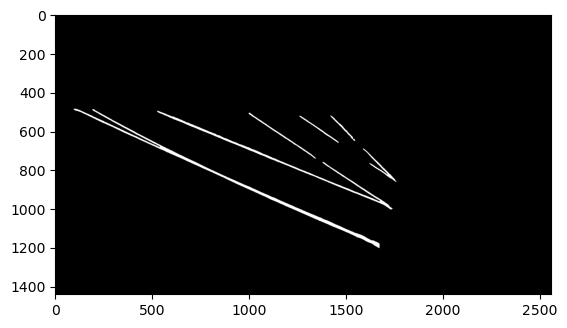

左端点:[760, 1381],右端点:[743, 1345]

左端点:[691, 1590],右端点:[652, 1548]

左端点:[521, 1421],右端点:[662, 1463]

连接，左端点:[743, 1345],右端点:[760, 1381]

斜率：0.4722222222222222
连接，左端点:[652, 1548],右端点:[691, 1590]

斜率：0.9285714285714286
连接，左端点:[521, 1421],右端点:[662, 1463]

斜率：3.357142857142857


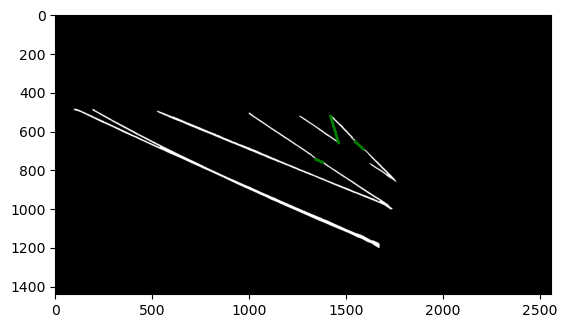

In [244]:
file_path = ".\\breakpoint\\"
file_name = ['2 (' + str(f) + ')'  for f in range(2,3)];
file_ext = ".png";

for f in file_name:
    file = file_path + f + file_ext;
    print(file_path + f + file_ext + "\n");
    BreakPointConnector(file_path,f,file_ext);  


In [245]:
#调用sobel边缘提取
# def sobel(Image):
#     x_sobel = cv2.Sobel(Image, cv2.CV_16S, 1, 0)
#     y_sobel = cv2.Sobel(Image, cv2.CV_16S, 0, 1)

#     absX = cv2.convertScaleAbs(x_sobel) # 转回unit8
#     absY = cv2.convertScaleAbs(y_sobel)

#     Image_sobel = cv2.addWeighted(absX, 0.5, absY, 0.5, 0);
    
#     [image_y_max,image_x_max] = Image_sobel.shape;
#     for y in range(image_y_max):
#         for x in range(image_x_max):
#             if Image_sobel[y,x] != 0:
#                 Image_sobel[y,x] = 1;
                
#     plt.imshow(Image_sobel,cmap = "gray");
#     plt.show();
#     return Image_sobel;


In [246]:
#采集上下边缘，求中值
# def refine(Image):
#     [image_y_max, image_x_max] =  Image.shape;
#     Image_refine = np.zeros((image_y_max,image_x_max));
#     for x in range(0,image_x_max): 
#         start = end  = 0;
#         for y in range(image_y_max-1,-1,-1):
#             v = x;
#             u = int(-y + image_y_max - 1);
#             if (Image[u,v] == 1):
#                 if (u == 0) or (Image[u-1,v] == 0):#开始
#                     start = u;
#                 if (u == image_y_max-1) or (Image[u+1,v] == 0):#结束 
#                     end = u;
#                 if(end != 0): # 遍历完一段曲线，求中，把start、end复原
#                     mid = int((start+end)/2);
#                     Image_refine[mid,v] = 1;
#                     start = end  = 0;
            
#     plt.imshow(Image_refine,cmap = "gray");
#     plt.show();
#     return Image_refine;

In [247]:
#裁剪原图片
# def extract_edge(Image,file_path,file_name):
#     [image_y_max,image_x_max] = Image.shape;
#     min_x = max_x = min_y = max_y = 0;
#     sum_col = np.sum(Image,axis=0);
#     for i in range(0,image_x_max):
#         if (sum_col[i] != 0):
#             min_x = i;
#             break;
#     for i in range(image_x_max-1,min_x,-1):
#         if (sum_col[i] != 0):
#             max_x = i;
#             break;


    # sum_row = np.sum(Image,axis=1);
    # for i in range(0,image_y_max):   
    #     if (sum_row[i] != 0):
    #         min_y = i;
    #         break; 
    # for i in range(image_y_max - 1,min_y,-1):
    #     if (sum_row[i] != 0):
    #         max_y = i;
    #         break;

    # Image = Image[min_y:max_y,min_x:max_x];

    # [image_y_max, image_x_max] =  Image.shape;
    # print('裁剪后高度:%d,裁剪后宽度:%d\n' %(image_y_max,image_x_max));
    
    # ## 像素矩阵的值改为0/1。
    # for i in range(0,image_x_max):
    #     for j in range(0,image_y_max):
    #         if (Image[j,i] != 0):
    #             Image[j,i] = 1;
                       
                
    # plt.xlim((0, image_x_max));
    # plt.ylim((image_y_max, 0));
    # plt.imshow(Image,cmap = "gray");
    # file = file_path + "cut\\" + file_name + "_cut.png";
    # plt.savefig(file);
    # plt.show();
    # return Image;